In [1]:
import torch

import copy

from vwgym.init_utils import *
from vwgym.fun_lite import *
from tensorboardX import SummaryWriter
from datetime import datetime
import time
import numpy as np
from tqdm import tqdm

torch.manual_seed(518123)

if torch.cuda.is_available():
    print('GPU Available:\t', True)
    device = 'cuda'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

else:
    device = 'cpu'

GPU Available:	 True


In [2]:
args = {
            'lr': 25e-4,
            'steps': 400,
            'max_steps': 1e8,
            'env_reboot':5e5,
            'entropy_coef': 0.01,
            'gamma': 0.99,
            'alpha': 0.5,
            'eps': 0.01,
            'grid_size': 3,
            'd': 256,
            'k': 16,
            'len_hist': 10,
            'grad_clip':5.0,
            'writer': True,
            'num_worker': 1

        }

In [3]:
# env, input_shape = make_env(args['grid_size'], args['num_worker'])
random.seed(518123)
env_n = VacuumWorld(args['grid_size'])
env_v = Vectorise(copy.deepcopy(env_n))
env = StepWrapper(env_v)

num_actions_wi = range(env.action_space.n)
num_actions = range(env.action_space.n - 1)

In [4]:
def observation(grid):
    
    dirt_table = {'green':128, 'orange':255}
    orientation_table = {'north':64, 'east':128, 'south':192, 'west':255}

    obs = 0

    c = next(iter(grid._get_agents().keys()))
    obs = 255 + c[1] + c[0]

    for c,a in grid._get_agents().items(): #all agents
        obs += c[1] + c[0] + orientation_table[a.orientation]

    for c,d in grid._get_dirts().items(): #all dirts
        obs += c[1] + c[0] + dirt_table[d.colour]
        
    return obs

In [5]:
from collections import defaultdict
Q = defaultdict(float)
gamma = args['gamma']  # Discounting factor
alpha = args['alpha']  # soft update param

def update_Q(s, r, a, s_next, done, Q, actions):
    max_q_next = max([Q[s_next, a] for a in actions]) 
    # Do not include the next state's value if currently at the terminal state.
#     print('\n', Q, '\n')
    Q[s, a] += alpha * (r + gamma * max_q_next * (1.0 - done) - Q[s, a])

In [6]:
def react(state, args, actions, q):
    
#     if np.random.random() < args['eps']:
#         return np.
    q_values = {a: q[state, a] for a in actions}
    max_q = max(q_values.values())
    
    actions_with_max_q = [a for a, q in q_values.items() if q == max_q]
    return np.random.choice(actions_with_max_q)

In [7]:
ob = env.reset()
env.rw_dirts = env.dirts
ob = observation(env.state())
rewards = []
reward = 0.0
history = []

for step in range(100000):
    a = react(ob, args, num_actions_wi, Q)
    ob_next, r, done, ep_info = env.step(a)
    ob_next = observation(env.state())
    update_Q(ob, r, a, ob_next, done, Q, num_actions_wi)
    reward += r
    if done:
        history.append(ep_info)
        rewards.append(reward)
        reward = 0.0
        ob = env.reset()
        env.rw_dirts = env.dirts
        ob = observation(env.state())
    else:
        ob = ob_next
        
    if len(history) > 20 and (history[-2] == history[-1]):
        break        


Grid Cleaned !!

{'ep_rewards': 409, 'ep_len': 197, 'move': 41, 'clean': 39, 'turn_left': 45, 'turn_right': 37, 'idle': 35}
Episode Rewards:	 409

Grid Cleaned !!

{'ep_rewards': 524, 'ep_len': 82, 'move': 15, 'clean': 17, 'turn_left': 19, 'turn_right': 16, 'idle': 15}
Episode Rewards:	 524

Grid Cleaned !!

{'ep_rewards': -119, 'ep_len': 725, 'move': 58, 'clean': 472, 'turn_left': 84, 'turn_right': 74, 'idle': 37}
Episode Rewards:	 -119

Grid Cleaned !!

{'ep_rewards': 346, 'ep_len': 260, 'move': 69, 'clean': 34, 'turn_left': 60, 'turn_right': 66, 'idle': 31}
Episode Rewards:	 346

Grid Cleaned !!

{'ep_rewards': 161, 'ep_len': 445, 'move': 88, 'clean': 300, 'turn_left': 27, 'turn_right': 16, 'idle': 14}
Episode Rewards:	 161

Grid Cleaned !!

{'ep_rewards': 196, 'ep_len': 410, 'move': 14, 'clean': 221, 'turn_left': 80, 'turn_right': 85, 'idle': 10}
Episode Rewards:	 196

Grid Cleaned !!

{'ep_rewards': 355, 'ep_len': 251, 'move': 41, 'clean': 41, 'turn_left': 68, 'turn_right': 62, '


Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583

Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583

Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583

Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583

Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583

Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583

Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583

Grid Cleaned

In [8]:
import pandas as pd

In [9]:
h = pd.DataFrame(history)
h

,ep_rewards,ep_len,move,clean,turn_left,turn_right,idle
0,409,197,41,39,45,37,35
1,524,82,15,17,19,16,15
2,-119,725,58,472,84,74,37
3,346,260,69,34,60,66,31
4,161,445,88,300,27,16,14
...,...,...,...,...,...,...,...
96,583,23,9,6,2,6,0
97,583,23,9,6,2,6,0
98,583,23,9,6,2,6,0
99,583,23,9,6,2,6,0


In [10]:
import matplotlib.pyplot as plt

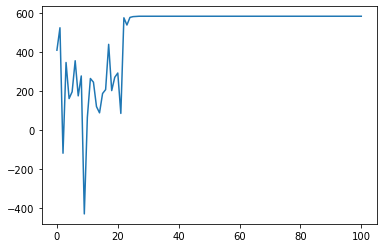

In [11]:
h['ep_rewards'].plot()

In [12]:
ob = env.reset()
env.rw_dirts = env.dirts
ob = observation(env.state())
rewards = []
reward = 0.0
history = []

for step in range(100000):
    a = react(ob, args, num_actions_wi, Q)
    history.append(a)
    ob_next, r, done, ep_info = env.step(a)
    ob_next = observation(env.state())
#     update_Q(ob, r, a, ob_next, done, Q, num_actions_wi)
    reward += r
    if done:
#         history.append(ep_info)
#         rewards.append(reward)
#         reward = 0.0
#         ob = env.reset()
#         env.rw_dirts = env.dirts
#         ob = observation(env.state())
        break
    else:
        ob = ob_next
        
#     if len(history) > 100 and (history[-2] == history[-1]):
        


Grid Cleaned !!

{'ep_rewards': 583, 'ep_len': 23, 'move': 9, 'clean': 6, 'turn_left': 2, 'turn_right': 6, 'idle': 0}
Episode Rewards:	 583


In [15]:
import pyworld.toolkit.tools.visutils.jupyter as J
import pyworld.toolkit.tools.gymutils as gu

In [18]:
print(len(history))
history.append(4)
print(len(history))
print(env_v.reset())

23
24
[[[  0 255   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0 128   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0 255 255]
  [128 128   0]
  [255   0 128]]]


In [19]:
ac_1 = iter(history)
ac_2 = iter(history)

nstate = gu.episode(env_n, lambda _: next(ac_1), max_length=len(history))[0]
vstate = gu.episode(env_v, lambda _: next(ac_2), max_length=len(history))[0]

vis = np.concatenate([vstate[:,None,i] for i in [0,1,2]], axis=3)

J.images(vis, scale=40, on_interact=list(zip(np.array(env.action_meanings)[history],nstate)));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=23), Output()), _dom…